In [1]:
import glob
import os
import h5py
import numpy as np
import json
import matplotlib.pyplot as plt

In [15]:
def get_stepsizes(exp_dir):
    with open(os.path.join(exp_dir, "info.json"), "r") as f:
        info = json.load(f)
    stepsizes = info["stepsizes"]
    return stepsizes

def plot_experiments(exp_name, base_dir="./simulation_results/", offset1=1, offset2=1):
    exp_dir = os.path.join(base_dir, exp_name)
    data_files = glob.glob(os.path.join(exp_dir, "*.h5"))
    stepsizes = get_stepsizes(exp_dir)

    for data_file in data_files:
        integrator_name = os.path.splitext(os.path.basename(data_file))[0]
        if integrator_name == "euler_maruyama1D":
            stepsizes0 = stepsizes[:-2]
        else:
            stepsizes0 = stepsizes
        # load the .h5 file to a numpy array
        convergence_data = np.array(h5py.File(data_file, 'r')['data'])

        mean_convergence = np.mean(convergence_data, axis=0)
        std_convergence = np.std(convergence_data, axis=0)

        # plot the mean convergence
        plt.plot(stepsizes0, mean_convergence, label=integrator_name)
        plt.fill_between(stepsizes0, mean_convergence - std_convergence,
                        mean_convergence + std_convergence, alpha=0.3)
        
    legend = plt.legend()
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.01))
    plt.ylabel("Mean L1 Error, invariant measure")
    plt.plot(stepsizes, offset1 * np.array(stepsizes), label="Gradient 1", color="black", linestyle="--", alpha=0.5)
    plt.plot(stepsizes, offset2 * np.array(stepsizes)**2, label="Gradient 2", color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Stepsize, h")
    plt.yscale('log')
    plt.xscale('log')
    fig = plt.gcf()
    fig.set_size_inches(10, 7)

In [25]:
def plot_times(exp_name, base_dir="./simulation_results/"):
    # open times.json
    exp_dir = os.path.join(base_dir, exp_name)
    with open(os.path.join(exp_dir, "times.json"), "r") as f:
        times = json.load(f)

    # plot the times
    plt.bar(times.keys(), [value/10**9 for value in times.values()])
    plt.ylabel("Time (s)")
    plt.xlabel("Integrator")
    plt.xticks(rotation=90)
    plt.show()

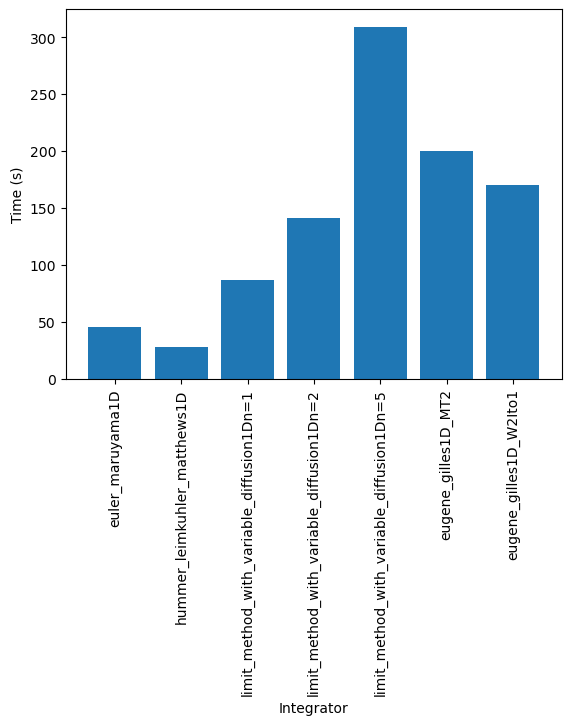

In [27]:
plot_times("quartic_cos_noise_1M")
# Note: the euler_maruyama1D integrator time includes the cost of compiling, so is an overestimate.

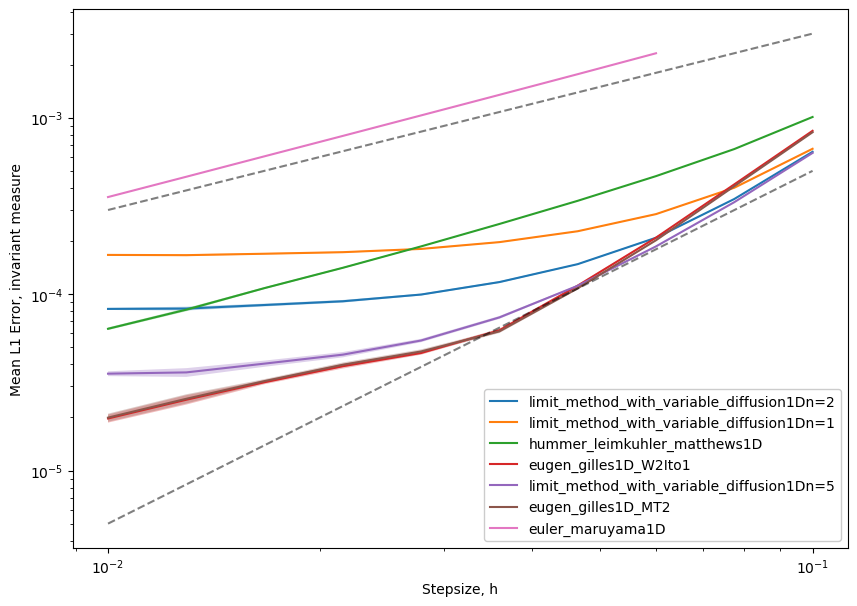

In [29]:
plot_experiments("quartic_cos_noise_50M", offset1=0.03, offset2=0.05)

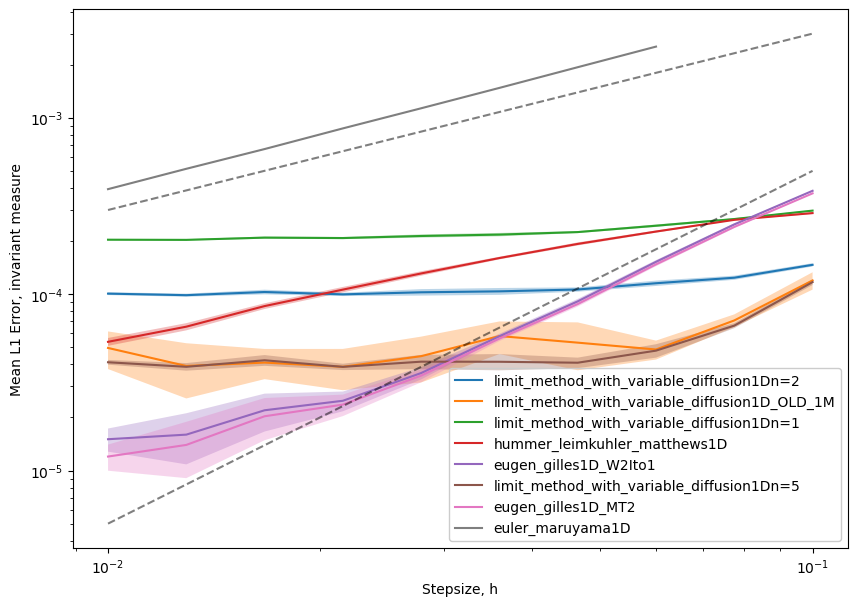

In [36]:
plot_experiments("quadratic_cos_noise_10M", offset1=0.03, offset2=0.05)

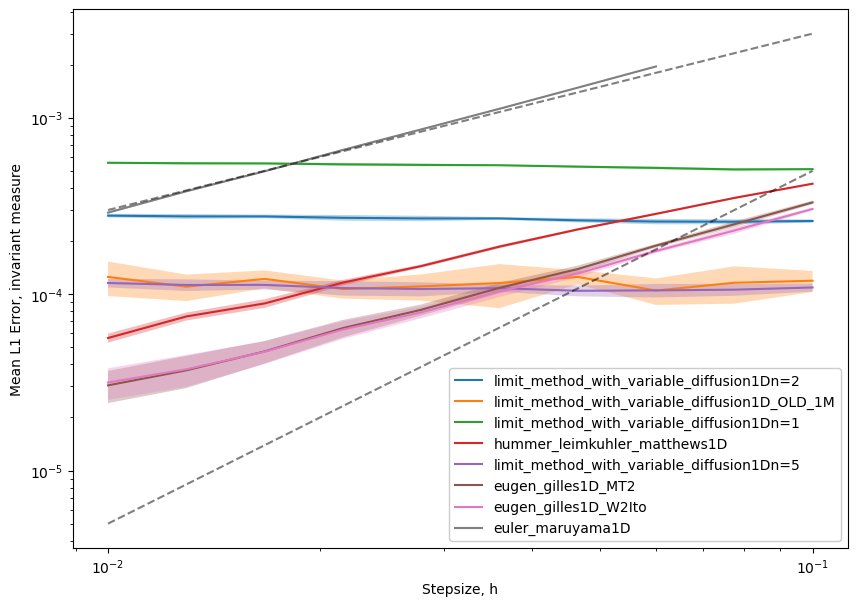

In [37]:
plot_experiments("quadratic_sin_noise_10M", offset1=0.03, offset2=0.05)

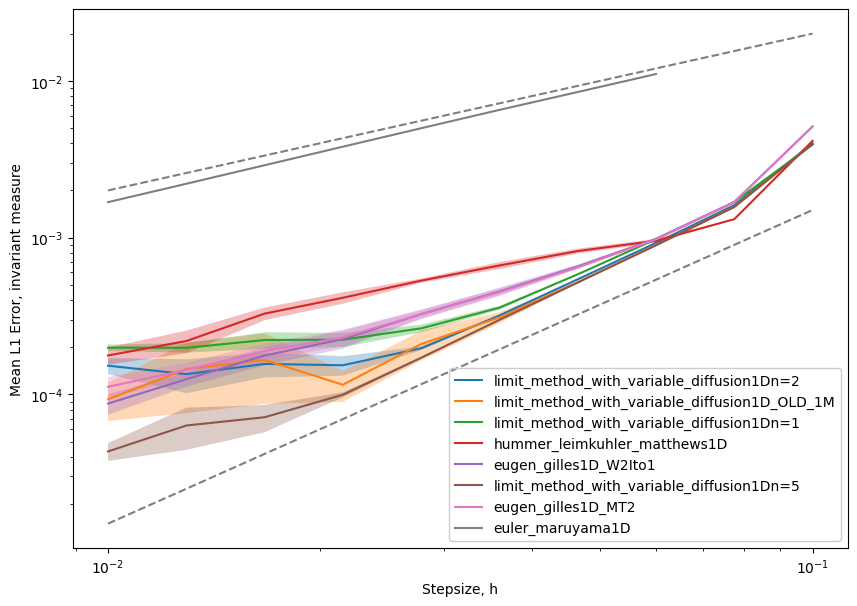

In [35]:
plot_experiments("softWell1D_10M", offset1=0.2, offset2=0.15)

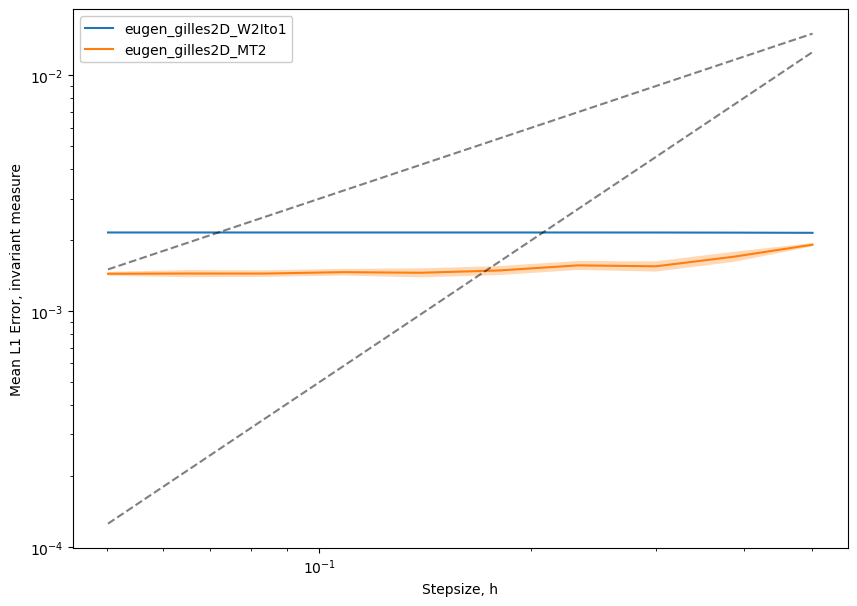

In [34]:
plot_experiments("anisotropicMoroCardin_10M", offset1=0.03, offset2=0.05)